# Clean code for executing a single experiment 

In [12]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import time
import argparse
import pickle
import fnmatch


from shallow_networks import *
# Tensorflow 2.0 way of doing things
from tensorflow.keras.layers import InputLayer, Dense
from tensorflow.keras.models import Sequential
 
from symbiotic_metrics import *
#import hw2_base
#from IPython.core.interactiveshell import InteractiveShell

#InteractiveShell.ast_node_interactivity = "all"
#################################################################
# Default plotting parameters
FONTSIZE = 18
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = FONTSIZE


In [3]:
print(tf.__version__)
# print(python.__version__)

2.1.0


In [4]:
# look at the data
 
fp = open("bmi_dataset.pkl", "rb")
foo = pickle.load(fp)
fp.close()

In [5]:
foo.keys()
# the daa set contains both neural and arm movement data
# theta, dtheta, ddtheta and torque and arm movement 
# time is a time stamp for each sample

dict_keys(['MI', 'theta', 'dtheta', 'ddtheta', 'torque', 'time'])

In [6]:
def create_parser():
    # Parse the command-line arguments
    parser = argparse.ArgumentParser(description='BMI Learner')
    parser.add_argument('-rotation', type=int, default=0, help='Cross-validation rotation')
    parser.add_argument('-epochs', type=int, default=100, help='Training epochs')
    parser.add_argument('-dataset', type=str, default='bmi_dataset.pkl', help='Data set file')
    parser.add_argument('-Ntraining', type=int, default=2, help='Number of training folds')
    parser.add_argument('-output_type', type=str, default='torque', help='Type to predict')
    parser.add_argument('-exp_index', type=int, default=-1, help='Experiment index')
    parser.add_argument('-Nfolds', type=int, default=20, help='Maximum number of folds')
    parser.add_argument('-results_path', type=str, default='./results', help='Results directory')
    parser.add_argument('-hidden', nargs='+', type=int, default=[100, 5], help='Number of hidden units per layer (sequence of ints)')
    parser.add_argument('-dropout', type=float, default=None, help='Dropout rate')
    parser.add_argument('-dropout_input', type=float, default=None, 
                        help='Dropout rate for input units')
    parser.add_argument('-lrate', type=float, default=0.001, help="Learning rate")
    parser.add_argument('-L2_regularizer', type=float, default=None, help="L2 regularization parameter")
    parser.add_argument('-min_delta', type=float, default=0.0, help="Minimum delta for early termination")
    parser.add_argument('-patience', type=int, default=100, help="Patience for early termination")
    parser.add_argument('-verbose', '-v', action='count', default=0, help="Verbosity level")
    parser.add_argument('-predict_dim', type=int, default=None, help="Dimension of the output to predict")
    
    return parser

def check_args(args):
    assert (args.rotation >= 0 and args.rotation < args.Nfolds), "Rotation must be between 0 and Nfolds"
    assert (args.Ntraining >= 1 and args.Ntraining <= (args.Nfolds-2)), "Ntraining must be between 1 and Nfolds-2"
    assert (args.dropout is None or (args.dropout > 0.0 and args.dropout < 1)), "Dropout must be between 0 and 1"
    assert (args.dropout_input is None or (args.dropout_input > 0.0 and args.dropout_input < 1)), "Dropout_input must be between 0 and 1"
    assert (args.lrate > 0.0 and args.lrate < 1), "Lrate must be between 0 and 1"
    assert (args.L2_regularizer is None or (args.L2_regularizer > 0.0 and args.L2_regularizer < 1)), "L2_regularizer must be between 0 and 1"
    

In [7]:
def extract_data(bmi, args):
    '''
    Translate BMI data structure into a data set for training/evaluating a single model
    
    @param bmi Dictionary containing the full BMI data set, as loaded from the pickle file.
    @param args Argparse object, which contains key information, including Nfolds, 
            predict_dim, output_type, rotation
            
    @return Numpy arrays in standard TF format for training set input/output, 
            validation set input/output and testing set input/output; and a
            dictionary containing the lists of folds that have been chosen
    '''
    # Number of folds in the data set
    ins = bmi['MI']
    Nfolds = len(ins)
    
    # Check that argument matches actual number of folds
    assert (Nfolds == args.Nfolds), "Nfolds must match folds in data set"
    
    # Pull out the data to be predicted
    outs = bmi[args.output_type]
    
    # Check that predict_dim is valid
    assert (args.predict_dim is None or (args.predict_dim >= 0 and args.predict_dim < outs[0].shape[1]))
    
    # Rotation and number of folds to use for training
    r = args.rotation
    Ntraining = args.Ntraining
    
    # Compute which folds belong in which set
    folds_training = (np.array(range(Ntraining)) + r) % Nfolds
    folds_validation = (np.array([Nfolds-2]) +r ) % Nfolds
    folds_testing = (np.array([Nfolds-1]) + r) % Nfolds
    # Log these choices
    folds = {'folds_training': folds_training, 'folds_validation': folds_validation,
            'folds_testing': folds_testing}
    
    # Combine the folds into training/val/test data sets
    ins_training = np.concatenate(np.take(ins, folds_training))
    outs_training = np.concatenate(np.take(outs, folds_training))
        
    ins_validation = np.concatenate(np.take(ins, folds_validation))
    outs_validation = np.concatenate(np.take(outs, folds_validation))
        
    ins_testing = np.concatenate(np.take(ins, folds_testing))
    outs_testing = np.concatenate(np.take(outs, folds_testing))
    
    # If a particular dimension is specified, then extract it from the outputs
    if args.predict_dim is not None:
        outs_training = outs_training[:,[args.predict_dim]]
        outs_validation = outs_validation[:,[args.predict_dim]]
        outs_testing = outs_testing[:,[args.predict_dim]]
    
    return ins_training, outs_training, ins_validation, outs_validation, ins_testing, outs_testing, folds



In [14]:
def execute_exp(args=None):
    '''
    Perform the training and evaluation for a single model
    
    @args Argparse arguments
    '''
    # Check the arguments
    if args is None:
        # Case where no args are given (usually, because we are calling from within Jupyter)
        #  In this situation, we just use the default arguments
        parser = create_parser()
        args = parser.parse_args([])
        
    # Modify the args in specific situations
    augment_args(args)
    
    # Load the data
    fp = open(args.dataset, "rb")
    bmi = pickle.load(fp)
    fp.close()
    
    # Extract the data sets
    ins, outs, ins_validation, outs_validation, ins_testing, outs_testing, folds = extract_data(bmi, args)
    
    # Metrics
    fvaf = FractionOfVarianceAccountedFor(outs.shape[1])
    rmse = tf.keras.metrics.RootMeanSquaredError()

    # Build the model
    model = shallow_network(ins.shape[1], tuple(args.hidden), outs.shape[1], 
                               activation='elu',
                               dropout=args.dropout,
                               dropout_input=args.dropout_input,
                              lrate=args.lrate,
                              kernel_regularizer=args.L2_regularizer, 
                              metrics=[fvaf, rmse])
    
    # Report if verbosity is turned on
    if args.verbose >= 1:
        print(model.summary())
    
    # Callbacks
    early_stopping_cb = keras.callbacks.EarlyStopping(patience=args.patience,
                                                      restore_best_weights=True,
                                                      min_delta=args.min_delta)
    
    # Learn
    history = model.fit(x=ins, y=outs, epochs=args.epochs, verbose=args.verbose>=2,
                        validation_data=(ins_validation, outs_validation), 
                        callbacks=[early_stopping_cb])
        
    # Generate log data
    results = {}
    results['args'] = args
    results['predict_training'] = model.predict(ins)
    results['predict_training_eval'] = model.evaluate(ins, outs)
    results['predict_validation'] = model.predict(ins_validation)
    results['predict_validation_eval'] = model.evaluate(ins_validation, outs_validation)
    results['predict_testing'] = model.predict(ins_testing)
    results['predict_testing_eval'] = model.evaluate(ins_testing, outs_testing)
    results['folds'] = folds
    results['history'] = history.history
    
    # Save results
    fbase = generate_fname(args)
    results['fname_base'] = fbase
    fp = open("%s_results.pkl"%(fbase), "wb")
    pickle.dump(results, fp)
    fp.close()
    
    # Model
    model.save("%s_model"%(fbase))
    return model

# %% self-defined model
def build_model1(n_inputs, n_hidden, n_output, activation='elu', lrate=0.001):
    model = Sequential();
    model.add(InputLayer(input_shape=(n_inputs,)))
    model.add(Dense(n_hidden, use_bias=True, name="hidden_1", activation=activation))
    model.add(Dense(n_hidden, use_bias=True, name="hidden_2", activation=activation))
    model.add(Dense(n_hidden-1, use_bias=True, name="hidden_3", activation=activation))
#     model.add(Dense(n_hidden, use_bias=True, name="hidden_4", activation=activation))
#     model.add(Dense(n_hidden, use_bias=True, name="hidden_5", activation=activation))
#     model.add(Dense(n_hidden, use_bias=True, name="hidden_6", activation=activation))
    model.add(Dense(n_output, use_bias=True, name="output", activation=activation))
    
    opt = tf.keras.optimizers.Adam(lr=lrate, beta_1=0.9, beta_2=0.999,
                                epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss='mse', optimizer=opt)
    print(model.summary())
    return model

def augment_args(args):
    '''
    This was an attempt to use the subjob number (specified using "--array" in SLURM) to 
    override certain experiment parameters.  This way, we can schedule an entire group of
    experiments, where one or more parameters vary systematically.  
    
    Since SLURM (as well as autoson) can only vary one variable, the challenge is how to
    map subjob numbers onto parameter values.  My approach with autoson was to reserve 
    certain digits of the number for specific experiment variables:
    
    Digits 0-1: experimental rotation (if 0 ... N)
    Digits 2-3: Number of training examples (if 1... N-2)
    
    However, it turns out that SLURM will only allow us to have subjob numbers up to 999
    (so, no digits beyond 3).  Will have to rethink this approach (the next attempt will be
    to not have gaps in the sequence)
    
    --array 0-19 will keep all parameters constant, except that it will vary the 
        rotation from 0 to 19
    --array 100-119,200-219 will keep all constan, except that it will vary the
        rotation from 0 to 19 and vary Ntraining from 1 to 2
    '''
    index = args.exp_index
    if(index == -1):
        return
    
    tmp = index % 100
    assert(tmp >= 0 and tmp < args.Nfolds), "EXP_IND: Rotation must be between 0 and Nfolds-1"
    args.rotation = tmp
        
    tmp = int(index/100) % 100
    assert(tmp >= 0 and tmp < args.Nfolds-2), "EXP_IND: Ntraining must be between 0 and Nfolds-2"
    if(tmp > 0):
        args.Ntraining = tmp
    
def generate_fname(args):
    '''
    Generate the base file name for output files/directories.
    
    The approach is to encode the key experimental parameters in the file name.  This
    way, they are unique and easy to identify after the fact.
    '''
    # Hidden unit configuration
    hidden_str = '_'.join(str(x) for x in args.hidden)
    
    # Dropout
    if args.dropout is None:
        dropout_str = ''
    else:
        dropout_str = 'drop_%0.2f_'%(args.dropout)
        
    if args.dropout_input is None:
        dropout_input_str = ''
    else:
        dropout_input_str = 'dropin_%0.2f_'%(args.dropout_input)
        
    # L2 regularization
    if args.L2_regularizer is None:
        regularizer_str = ''
    else:
        regularizer_str = 'L2_%0.6f_'%(args.L2_regularizer)
    
    # Dimension being predicted
    if args.predict_dim is None:
        predict_str = args.output_type
    else:
        predict_str = '%s_%d'%(args.output_type, args.predict_dim)
        
    # Put it all together, including #of training folds and the experiment rotation
    return "%s/bmi_%s_hidden_%s_%s%s%sntrain_%02d_rot_%02d"%(args.results_path, 
                                                             predict_str,
                                                          hidden_str, 
                                        dropout_str, dropout_input_str, 
                                        regularizer_str,
                                        args.Ntraining, args.rotation)

In [15]:
q_parser = create_parser()
# argsa.attributes()

args = q_parser.parse_args([])
# argparse.ArgumentParser(description='BMI Learner')

check_args(args)

In [16]:
ins_training, outs_training, ins_validation, outs_validation, ins_testing, outs_testing, folds = extract_data(foo,args)

In [20]:
args

Namespace(L2_regularizer=None, Nfolds=20, Ntraining=2, dataset='bmi_dataset.pkl', dropout=None, dropout_input=None, epochs=100, exp_index=-1, hidden=[100, 5], lrate=0.001, min_delta=0.0, output_type='torque', patience=100, predict_dim=None, results_path='./results', rotation=0, verbose=0)

In [17]:
execute_exp(args) #let's use the default args(see args function above)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden0 (Dense)              (None, 100)               96100     
_________________________________________________________________
hidden1 (Dense)              (None, 5)                 505       
_________________________________________________________________
output (Dense)               (None, 2)                 12        
Total params: 96,617
Trainable params: 96,617
Non-trainable params: 0
_________________________________________________________________
None
1289/1289 [==============================] - 0s 27us/sample - loss: 0.0066 - fvaf: -0.1173 - root_mean_squared_error: 0.0813
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./results/bmi_torque_hidden_100_5_ntrain_02_rot_00_model/assets


In [53]:
filebase = "./results/bmi_torque_hidden_100_5_ntrain_02_rot_00_results.pkl"

# filebase = "./bmi_torque_hidden_100_5_ntrain_02_rot_00_results"
results = read_all_rotations("results", filebase)

In [60]:
fp = open("./results/bmi_torque_hidden_100_5_ntrain_02_rot_00_results.pkl", "rb")
foo = pickle.load(fp)
fp.close()

array([[-0.13944077, -0.04986966],
       [-0.18799281, -0.03045774],
       [-0.22412097, -0.04275829],
       ...,
       [-0.03202456,  0.01722929],
       [-0.02307582,  0.02326396],
       [ 0.02859511,  0.03527794]], dtype=float32)

Text(0, 0.5, 'torque(N-m)')

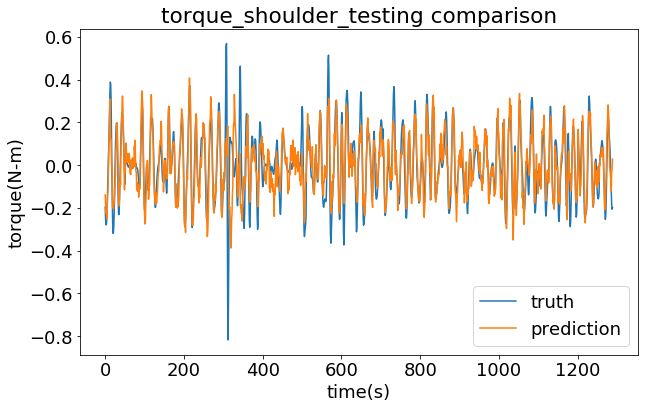

In [70]:
plt.plot(outs_testing[:,0],label = 'truth')
plt.plot(foo['predict_testing'][:,0],label='prediction')
plt.title('torque_shoulder_testing comparison')
plt.legend()
plt.xlabel('time(s)')
plt.ylabel('torque(N-m)')


Text(0, 0.5, 'torque(N-m)')

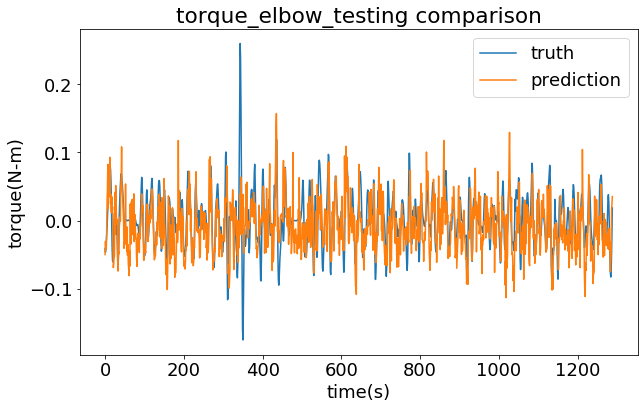

In [72]:
plt.plot(outs_testing[:,1],label = 'truth')
plt.plot(foo['predict_testing'][:,1],label='prediction')
plt.title('torque_elbow_testing comparison')
plt.legend()
plt.xlabel('time(s)')
plt.ylabel('torque(N-m)')